# NBA Playoff Analysis: What stars improved or declined in performance the most?
### Introduction
This analysis aims to identify which NBA stars performance improved or declined the most from the regular season to the playoffs. I'll accomplish this by scraping regular season and playoff data from basketball reference, creating critera for players/seasons to evaluate, and pinpointing a few stats that best tell the story of the change in a player's individual performance.

### Pulling the Data

First, I begin by web-scraping data from BasketballReference using the BeautifulSoup library. I'll be pulling individual player's season-long statistics for every season between 1979/1980 and 2019/2020. The 1979/1980 season was chosen to start with because it was the first season where the 3 point line was introduced, a key factor for our analysis.

Two types of data will be pulled for both regular season and playoffs: <br> 1. per/100 posession data <br> 2. "Advanced" data on bball ref - which really means stats like Win Shares, BPM, TS%, etc.

In [1]:
#Import libaries
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create date ranges for data pull: 1978-2020 (1978 was the first year turnovers were tracked in box score data)
years = list(range(1980,2021))

# Initialize varibles used for data pull function
data_types = ['leagues', 'playoffs']
stat_types = ['per_poss','advanced']

In [3]:
# Create function to pull the 4 different datasets we need
def data_pull(dtype,stat,year_list):
    final_df = pd.DataFrame()
    for year in year_list:
        url = "https://www.basketball-reference.com/{}/NBA_{}_{}.html".format(dtype,year,stat)
        html = urlopen(url)
        soup = BeautifulSoup(html)

        # use findALL() to get the column headers
        soup.findAll('tr', limit=2)
        # use getText()to extract the text we need into a list
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
        headers = headers[1:]
        headers.append('Season')

        # avoid the first header row
        rows = soup.findAll('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        # add season column
        season = year
        player_stats = [player + [season] for player in player_stats]  

        # append each season to dataframe
        year_df = pd.DataFrame(player_stats)
        year_df.columns = headers
        final_df = final_df.append(year_df)

    # drop null season columns and change type to int
    final_df = final_df.dropna(subset = ['Season'])
    final_df = final_df.astype({'Season': int})

    return final_df

In [4]:
# Loop through function to create each dataframe needed
df_list = []
for dtype in data_types:
    for stat in stat_types:
        df = data_pull(dtype,stat,years)
        df_list.append(df)

In [5]:
# Assinging dataframes for easier functionality
reg_per100_df = df_list[0]
reg_adv_df = df_list[1]
play_per100_df = df_list[2]
play_adv_df = df_list[3]

### Developing Player Criteria
Now I need to develop some sort of criteria to narrow down the players to focus on. It makes more sense to start by narrowing down our playoff players, since there are less of them in general. I want to make sure I have players with a large enough sample size of playoff performance, and with enough high quality playoff "seasons" to evaluate properly.<br> <br> **1. Peak Seasons**: I want to only capture the prime seasons of each player, both regular season and playoff. This makes sure that I'm comparing peak vs peak seasons for all players and that players aren't negatively impacted by their declining performance as they got older. Our first critera will be only regular season or playoffs with an Offensive BPM >= 3. In addition, I'll create a minutes critera of >= 1000 for regular seasons to avoid counting seasons where a player was injured for most of it but had a high BPM when healthy. BPM of 3 falls between what Basketball Reference defines as a good starter (BPM of 2) and a all-star (BPM of 4) <br> *You can read more about BPM here: https://www.basketball-reference.com/about/bpm2.html#:~:text=BPM%20uses%20a%20player's%20box,is%20purely%20a%20rate%20stat!* <br> **2. Playoff Minutes Played**: Using a rough estimate of 400 minutes per playoffs for a typical "star" player (slightly lower than your typical superstar to account for great players consistently losing early/quickly in the playoffs; Tracy McGrady is notoriously know for this), I'll use 2000 playoff minutes as our second critera. Additionally, I'll only count playoff seasons with >= 150 minutes played, to account for years where the player either got injured early in the playoffs or was a role player. This will allow me to narrow down our view to players who played a good amount of total playoff minutes and playoff seasons in which they were playing "starter" level minutes. <br> **3. Quality Playoff Seasons**: One flaw with the minutes critera is that it skews more towards longevity rather than peak, which in turn skews more towards role players rather than stars. Derek Fisher played almost 7000 playoff minutes in his career, and he's definitely no star. So the third critera will be players with 5 or more seasons of a playoff BPM >= 3. <br> <br> The following three conditions should allow the analysis to focus on star players in their prime, which would give the most accurate like-for-like performance comparisons.


In [6]:
# Clean up any null fields
reg_per100_df = reg_per100_df.replace({'': 0})
play_per100_df = play_per100_df.replace({'': 0})
reg_adv_df = reg_adv_df.replace({'': 0})
play_adv_df = play_adv_df.replace({'': 0})

# Convert the fields used to their proper data type
convert_dict = {'3PA': float,
               '3P%': float,
               'AST': float,
               'PTS': float,
               'TOV': float,
               'FGA': float,
               'FTA': float,
               'MP': int}

reg_per100_df = reg_per100_df.astype(convert_dict)
play_per100_df = play_per100_df.astype(convert_dict)

# Convert any remaining fields left to be converted
convert_dict2 = {'TS%': float,
                'OBPM': float,
                'TOV%': float,
                'MP': int}
reg_adv_df = reg_adv_df.astype(convert_dict2)
play_adv_df = play_adv_df.astype(convert_dict2)


# Filter for regular seasons with minutes played >= 1000
reg_per100_df = reg_per100_df[reg_per100_df['MP'] >= 1000]
reg_adv_df = reg_adv_df[reg_adv_df['MP'] >= 1000]

# Filter for playoff seasons with minutes played >= 150
play_per100_df = play_per100_df[play_per100_df['MP'] >= 120]
play_adv_df = play_adv_df[play_adv_df['MP'] >= 120]

In [7]:
# Convert OBPM played to float
reg_adv_df = reg_adv_df.astype({'OBPM': 'float'})
play_adv_df = play_adv_df.astype({'OBPM': 'float'})

# Create OBPM >= 3 indicator column 
play_adv_df['OBPM_gt3'] = play_adv_df['OBPM'] >= 3
play_adv_df['OBPM_gt3'] = play_adv_df['OBPM_gt3'].astype(int)

# Filter for players with >= 2000 playoff minutes and at least 5 seasons with a playoff BPM >= 3
playoff_players = play_adv_df.groupby("Player", as_index = False).agg({'MP':sum, 'OBPM_gt3': sum})
playoff_players = playoff_players[(playoff_players['OBPM_gt3'] >= 5) & (playoff_players['MP'] >= 2000)]

In [8]:
# Final list of players for analysis
players_list = list(playoff_players['Player'])
players_list

['Allen Iverson*',
 'Anfernee Hardaway',
 'Carmelo Anthony',
 'Charles Barkley*',
 'Chauncey Billups',
 'Chris Paul',
 'Clyde Drexler*',
 'Damian Lillard',
 'David Robinson*',
 'Deron Williams',
 'Dirk Nowitzki',
 'Dwyane Wade',
 'Gary Payton*',
 'Hakeem Olajuwon*',
 'Isiah Thomas*',
 'James Harden',
 'James Worthy*',
 'John Stockton*',
 'Kareem Abdul-Jabbar*',
 'Karl Malone*',
 'Kawhi Leonard',
 'Kevin Durant',
 'Kevin Garnett*',
 'Kevin Johnson',
 'Kobe Bryant*',
 'Larry Bird*',
 'LeBron James',
 'Magic Johnson*',
 'Michael Jordan*',
 'Moses Malone*',
 'Pau Gasol',
 'Ray Allen*',
 'Reggie Miller*',
 'Russell Westbrook',
 'Scottie Pippen*',
 "Shaquille O'Neal*",
 'Stephen Curry',
 'Steve Nash*',
 'Terry Porter',
 'Tim Duncan*']

In [9]:
# Filter each df for only players that appear in our final players list
reg_per100_df = reg_per100_df[reg_per100_df['Player'].isin(players_list)]
reg_adv_df = reg_adv_df[reg_adv_df['Player'].isin(players_list)]
play_per100_df = play_per100_df[play_per100_df['Player'].isin(players_list)]
play_adv_df = play_adv_df[play_adv_df['Player'].isin(players_list)]

In [10]:
# Filter for regular and playoff seasons with >= 3 OBPM
reg_adv_df = reg_adv_df[reg_adv_df['OBPM'] >= 3]
play_adv_df = play_adv_df[play_adv_df['OBPM'] >= 3]

### Choosing the right statistics
After narrowing down the final players list and keeping only their prime regular seasons and playoffs, now I'll need to determine what statistics to use in order to properly evaluate performance. Determining which stats properly evaluate an indvidual player's performance is always going to be a subjective task, so I'll attempt to pick/create statistics that I feel properly evaluate an individual's performance, regardless of team performance or opponent strength. <br><br> **1. Box Plus/Minus (BPM)**: BPM is a basketball box score-based metric that estimates a basketball player’s contribution to the team when that player is on the court. It is based only on the information in the traditional basketball box score--no play-by-play data or non-traditional box score data (like dunks or deflections) are included. <br> I'll only keep Offensive BPM because typically, BPM is a much more accurate way to represent offensive performance compared to defensive. <br> **2. True Shooting %**: True Shooting % is a measure of shooting efficiency that takes into account 2-point field goals, 3-point field goals, and free throws. To summarize, it aggregates field goal %, free throw %, and three point %, while placing weights on each category based on their potential point values. <br> **3. Points per/100 possessions**: The amount of points a player scores, scaled out to 100 possessions. Scaling every player's scoring to 100 possessions allows us to compare players scoring like-for-like regardless of era (1990s teams played slower than present day teams) or team pace (Milwaukee 2019-200 had 107 possessions per game while Charlotte 2019-2020 had 98). <br> **4. Turnover %**: Including some kind of negative stat is important for player analysis, so I've decided to go with turnover % as it feels like the negative stat that's least dependent on team performance. Turnover % is an estimate of turnovers committed per 100 plays. <br> **5. Box Creation**: This is the first of two custom built stats, that I found while doing research for this analysis. An overall view of Box Creation is that it incorporates all areas of "creation" for a player by calculating the interaction of scoring volume, assists and shooting. It incorporates a 3pt proficiency sigmoid function that helps to combine 3pt volume and efficiency in one holistic number. <br> *You can read more about Box Creation here: https://fansided.com/2017/08/11/nylon-calculus-measuring-creation-box-score/* <br> The formula for Box Creation is: <br> ***Creation = Ast x 0.1843+(Pts+TOV) x 0.0969-2.3021 x (3pt proficiency)+0.0582 x (Ast x (Pts+TOV) x 3pt proficiency)-1.1942*** <br> where <br> ***3pt proficiency = (2/(1+EXP(-3PA))-1)*3P%*** <br>and all stats are per 100 <br> **6. Offensive Load**: Building off Box Creation, Offensive Load is a way to capture how much a player "directly" contributes to an individual possession. It helps to measure an individual's shooting, creation, passing, and turnovers. <br> *You can read more about Offensive Load here: https://backpicks.com/2017/10/16/offensive-load-and-adjusted-tov/* <br> The formula for Offensive Load is: <br> ***Offensive Load = ((Assists-(0.38 x Box Creation)) x 0.75)+FGA+FTA x 0.44+Box Creation+Turnovers*** where all stats are per 100

In [11]:
# Create 3pt proficiency
reg_per100_df['3pt_prof'] = round((2/(1+np.exp(-1*reg_per100_df['3PA']))-1)*reg_per100_df['3P%'],4)
play_per100_df['3pt_prof'] = round((2/(1+np.exp(-1*play_per100_df['3PA']))-1)*play_per100_df['3P%'],4)

# Create Box Creation
reg_per100_df['box_creation'] = round(reg_per100_df['AST']*0.1843+(reg_per100_df['PTS']+reg_per100_df['TOV'])*0.0969-2.3021*(reg_per100_df['3pt_prof'])+0.0582*(reg_per100_df['AST']*(reg_per100_df['PTS']+reg_per100_df['TOV'])*reg_per100_df['3pt_prof'])-1.1942,4)
play_per100_df['box_creation'] = round(play_per100_df['AST']*0.1843+(play_per100_df['PTS']+play_per100_df['TOV'])*0.0969-2.3021*(play_per100_df['3pt_prof'])+0.0582*(play_per100_df['AST']*(play_per100_df['PTS']+play_per100_df['TOV'])*play_per100_df['3pt_prof'])-1.1942,4)

# Create Offensive Load
reg_per100_df['offensive_load'] = round(((reg_per100_df['AST']-(0.38*reg_per100_df['box_creation']))*0.75)+reg_per100_df['FGA']+reg_per100_df['FTA']*0.44+reg_per100_df['box_creation']+reg_per100_df['TOV'],4)
play_per100_df['offensive_load'] = round(((play_per100_df['AST']-(0.38*play_per100_df['box_creation']))*0.75)+play_per100_df['FGA']+play_per100_df['FTA']*0.44+play_per100_df['box_creation']+play_per100_df['TOV'],4)

The next 2 steps are going to be aggregating the average of each stat for each player across all of their seasons, and then merging the dataframes while only keeping the small list of stats I want to analyze. This will allow me to get a viewpoint of a player's entire regular season and playoff career.

In [12]:
# Calculate career averages for relevant stats
agg_reg_per100_df = reg_per100_df.groupby("Player", as_index = False).agg({'PTS':'mean', 'box_creation':'mean', 'offensive_load': 'mean'})
agg_play_per100_df = play_per100_df.groupby("Player", as_index = False).agg({'PTS':'mean', 'box_creation':'mean', 'offensive_load': 'mean'})
agg_reg_adv_df = reg_adv_df.groupby("Player", as_index = False).agg({'TS%':'mean','TOV%':'mean', 'OBPM':'mean'})
agg_play_adv_df = play_adv_df.groupby("Player", as_index = False).agg({'TS%':'mean','TOV%':'mean', 'OBPM':'mean'})

In [13]:
# Merge the regular season and playoff dataframes into 2 complete dfs
final_reg_df = agg_reg_per100_df.merge(agg_reg_adv_df, on = 'Player', how = 'left')
final_playoff_df = agg_play_per100_df.merge(agg_play_adv_df, on = 'Player', how = 'left')

# Convert TS% to a percentage
final_reg_df['TS%'] = final_reg_df['TS%'] * 100
final_playoff_df['TS%'] = final_playoff_df['TS%'] * 100

In [15]:
# Create a dataframe with differences between regular season and playoff stats
diff_df = final_playoff_df.set_index('Player').subtract(final_reg_df.set_index('Player'), fill_value=0)

# Create ranks for each column
for col in diff_df:
    if col == 'TOV%':
        diff_df["{}_rank".format(col)] = diff_df[col].rank(ascending=True)
    else:
        diff_df["{}_rank".format(col)] = diff_df[col].rank(ascending=False)

# Create total rank/score
rank_cols = [col for col in diff_df.columns if 'rank' in col]    
diff_df['total_rank'] = diff_df[rank_cols].sum(axis=1)

### Plotting Performance Changes: Data Visualization

I'll build some plots to help visualize the difference between regular season and playoff performance on a few significant statistics. This can help give an easy way to find some patterns or consistently among groups of players who are playoff performers vs playoff dissapointments.

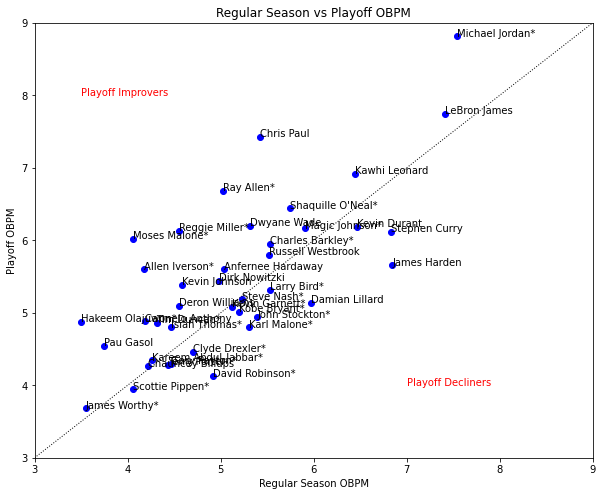

In [213]:
# Plot regular season OBPM vs playoff OBPM
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# Set player list
variablelabel = list(final_reg_df['Player'])

# Plot data
plt.plot(final_reg_df['OBPM'], final_playoff_df['OBPM'], "o", color='b')

# Plots mean lines
#plt.plot([final_reg_df['OBPM'].mean(),final_reg_df['OBPM'].mean()], [9,3], 'k-', linestyle = ":", lw=1)
#plt.plot([3,9], [final_playoff_df['OBPM'].mean(),final_playoff_df['OBPM'].mean()], 'k-', linestyle = ":", lw=1)

# Set axis limits and plot midline
plt.xlim(3, 9)
plt.ylim(3, 9)
ax.plot([0,1],[0,1],'k-', linestyle =":", lw=1, transform=ax.transAxes)

# Create variable labels
for i,txt in enumerate(variablelabel):
    plt.annotate(txt, (final_reg_df['OBPM'][i], final_playoff_df['OBPM'][i]), size='10')
    
ax.set_xlabel('Regular Season OBPM')
ax.set_ylabel('Playoff OBPM')
ax.set_title('Regular Season vs Playoff OBPM')

ax.text(7,4,"Playoff Decliners",color="red",size="10")
ax.text(3.5,8,"Playoff Improvers",color="red",size="10")

plt.show()

Viewing the OBPM scatter plot for regular season vs playoff performance gives some interesting insights. There doesnt appear to be any extremes in terms of OBPM regular season vs playoff variance, which is as expected. These are the prime years for some of the greatest players in NBA history, so there's a limit as to how much their performance will truely decline. <br> <br> Just from visualizing the data, some significant playoff improvers in terms of OBPM are ***Michael Jordan, Chris Paul, Ray Allen, and Moses Malone***. Some significant playoff decliners in terms of OBPM are ***James Harden, Damian Lillard, Stephen Curry, and David Robinson***. 

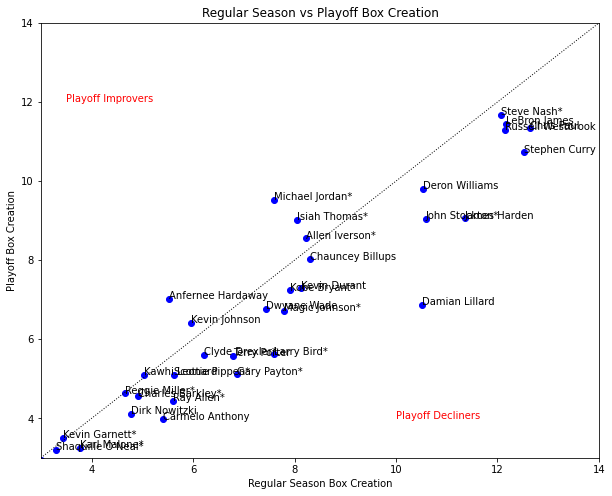

In [214]:
# Plot regular season Box creation vs playoff Box Creation
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# Set player list
variablelabel = list(final_reg_df['Player'])

# Plot data
plt.plot(final_reg_df['box_creation'], final_playoff_df['box_creation'], "o", color='b')

# Plots mean lines
#plt.plot([final_reg_df['box_creation'].mean(),final_reg_df['box_creation'].mean()], [9,3], 'k-', linestyle = ":", lw=1)
#plt.plot([3,9], [final_playoff_df['box_creation'].mean(),final_playoff_df['box_creation'].mean()], 'k-', linestyle = ":", lw=1)

# Set axis limits and plot midline
plt.xlim(3, 14)
plt.ylim(3, 14)
ax.plot([0,1],[0,1],'k-', linestyle =":", lw=1, transform=ax.transAxes)

# Create variable labels
for i,txt in enumerate(variablelabel):
    plt.annotate(txt, (final_reg_df['box_creation'][i], final_playoff_df['box_creation'][i]), size='10')
    
ax.set_xlabel('Regular Season Box Creation')
ax.set_ylabel('Playoff Box Creation')
ax.set_title('Regular Season vs Playoff Box Creation')

ax.text(10,4,"Playoff Decliners",color="red",size="10")
ax.text(3.5,12,"Playoff Improvers",color="red",size="10")

plt.show()

Viewing the Box Creation scatter plot for regular season vs playoff performance shows that for most players, Box Creation score actually decreased in the playoffs when compared to their regular season performance. I would account most of that difference for the playoffs just generally being harder than the regular season in terms of competition, travel schedules, constant oppositional adjustments, etc. <br> <br> Just from visualizing the data, some significant playoff improvers in terms of Box Creation are ***Michael Jordan, Penny Hardaway, and Isiah Thomas***. Some significant playoff decliners in terms of Box Creation are ***James Harden, Damian Lillard, and Stephen Curry***. These 3 decliners are also some of the biggest decliners in regular season vs playoff OBPM that was plotted previously, so there's a clear pattern emerging.

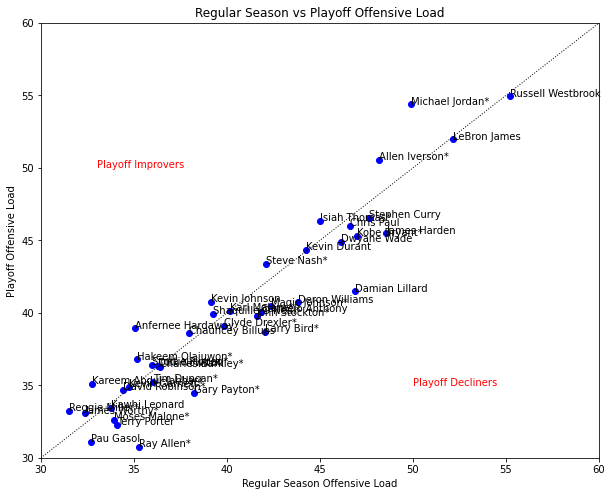

In [215]:
# Plot regular season Offensive Load vs playoff Offensive Load
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# Set player list
variablelabel = list(final_reg_df['Player'])

# Plot data
plt.plot(final_reg_df['offensive_load'], final_playoff_df['offensive_load'], "o", color='b')

# Plots mean lines
#plt.plot([final_reg_df['offensive_load'].mean(),final_reg_df['offensive_load'].mean()], [9,3], 'k-', linestyle = ":", lw=1)
#plt.plot([3,9], [final_playoff_df['offensive_load'].mean(),final_playoff_df['offensive_load'].mean()], 'k-', linestyle = ":", lw=1)

# Set axis limits and plot midline
plt.xlim(30, 60)
plt.ylim(30, 60)
ax.plot([0,1],[0,1],'k-', linestyle =":", lw=1, transform=ax.transAxes)

# Create variable labels
for i,txt in enumerate(variablelabel):
    plt.annotate(txt, (final_reg_df['offensive_load'][i], final_playoff_df['offensive_load'][i]), size='10')
    
ax.set_xlabel('Regular Season Offensive Load')
ax.set_ylabel('Playoff Offensive Load')
ax.set_title('Regular Season vs Playoff Offensive Load')

ax.text(50,35,"Playoff Decliners",color="red",size="10")
ax.text(33,50,"Playoff Improvers",color="red",size="10")

plt.show()

Viewing the Offensive Load scatter plot for regular season vs playoff performance shows even less variance than Box Creation in terms of regular season vs playoff performance. In my opinion, this is to be expected. Players of this caliber who carry a large load in the regular season typically will continue to carry said load in the playoffs as well, barring any kind of injury. <br> However, players who can actually improve on areas such as Offensive Load or Box Creation while maintaining or improving their efficiency should be considered some of the most valuable players of all time. Improving volume + efficiency in a more competitive environment like the playoffs is the sign of a truly outstanding player. <br> <br> Just from visualizing the data, some significant playoff improvers in terms of Offensive Load are ***Michael Jordan, Allen Iverson, and Penny Hardaway***. Some significant playoff decliners in terms of Offensive Load are ***Damian Lillard, Ray Allen, and Gary Payton***.

### Final Conclusions

I created a ranking system for each of the categories I looked at to rank each player's improvement in each cateogry relative to everyone else. The lower the rank, the larger the improvement in playoff performance compared to the regular season performance in that specific category. After summing up the ranks, the player with the lowest total score is the player who had the largest improvement from regular season to playoffs.

In [18]:
# Top 5 playoff improvers by total ranking system
diff_df.sort_values('total_rank', ascending=True).head(5)

,PTS,box_creation,offensive_load,TS%,TOV%,OBPM,PTS_rank,box_creation_rank,offensive_load_rank,TS%_rank,TOV%_rank,OBPM_rank,total_rank
Player,,,,,,,,,,,,,
Hakeem Olajuwon*,2.609524,0.212149,1.656929,2.046667,-1.303333,1.380000,4.0,6.0,6.0,2.0,15.0,6.0,39.0
Reggie Miller*,2.737302,-0.020594,1.744017,0.790909,-1.454545,1.572727,3.0,10.0,5.0,6.0,13.0,4.0,41.0
Allen Iverson*,1.910833,0.316880,2.383006,-1.438889,-2.161111,1.422222,6.0,5.0,3.0,24.0,6.0,5.0,49.0
Michael Jordan*,2.815385,1.928846,4.490969,-0.491667,0.386538,1.273718,2.0,1.0,1.0,13.0,37.0,7.0,61.0
Anfernee Hardaway,3.160000,1.500030,3.847275,-3.460000,-1.886667,0.566667,1.0,2.0,2.0,35.0,10.0,13.0,63.0


***Hakeem Olajuwon*** was actually the player who improved their playoff performance the most compared to the regular season. Hakeem had well rounded improvements in all categories, most importantly improving his scoring rate as well as his efficiency, while reducing his turnovers. I'm sure had I included some defensive metrics, he would have performed even better given his outstanding defensive reputation as well. Many of the other top playoff improvers appeared on the earlier visualizations, confirming the results seen via visuals. <br><br> Rounding out the rest of the top 5 biggest playoff **improvers** are: <br>***Reggie Miller*** - Improvement largely driven by the extremely impressive and valuable trait of improving both scoring volume (PTS) and scoring efficiency (TS%) while also carrying a greater offensive load <br> ***Allen Iverson*** - Increased scoring volume and offensive load <br> ***Michael Jordan*** - Largest improvement in box creation and offensive load with the second largest scoring improvement, but really hurt by an increase in turnovers. <br> ***Penny Hardaway*** - Surprisingly, very similar improvements to MJ in terms of scoring, box creation, and offesnive load, but hurt by a big drop in shooting efficiency. I also don't think his prime years were long enough to make a truly strong case one way or another.

In [19]:
# Top 5 playoff improvers by total ranking system
diff_df.sort_values('total_rank', ascending=False).head(5)

,PTS,box_creation,offensive_load,TS%,TOV%,OBPM,PTS_rank,box_creation_rank,offensive_load_rank,TS%_rank,TOV%_rank,OBPM_rank,total_rank
Player,,,,,,,,,,,,,
Damian Lillard,-3.394643,-3.628832,-5.376225,-1.548571,1.180000,-0.831429,40.0,40.0,40.0,25.0,40.0,39.0,224.0
Larry Bird*,-3.018939,-1.979535,-3.377081,-2.790000,0.470000,-0.210000,39.0,38.0,37.0,32.0,38.0,32.0,216.0
James Harden,-2.609091,-2.300582,-3.083818,-3.833333,-0.388889,-1.188889,37.0,39.0,35.0,38.0,24.0,40.0,213.0
Stephen Curry,-0.185714,-1.787611,-1.083263,-2.498214,0.101786,-0.723214,21.0,37.0,26.0,28.0,32.0,37.0,181.0
Gary Payton*,-2.112782,-1.760020,-3.749411,-0.186667,0.076667,-0.170000,34.0,36.0,38.0,10.0,31.0,30.0,179.0


Unsurprising given what the data visualization showed, but ***Damian Lillard*** was actually the player who's playoff performance declined the most compared to their regular season performance. It's kind of surprising to see Lillard as the biggest playoff decliner when thinking about all of his clutch playoff shots over the years, but I suspect that his extremely poor 2018 playoff performance is driving this ranking substantially. In terms of specific stats, Dame declines the most out of any player in scoring, box creation, and offensive load, as well as increasing his turnovers the most out of any player. <br>On the other hand, seeing the data back up what the playoff narrative has been about ***James Harden*** seems to confirm that his playoff performance does decline, especially when compared to how great his most recent regular seasons have been. He has big declines in almost every category and ranks at or near the bottom among the final player pool in each category.<br><br> Rounding out the rest of the top 5 biggest playoff **decliners** are: <br> ***Larry Bird*** - Also surprising given his reputation, but declines similarly to Harden with emphasis on decreased scoring volume and efficiency. Notable postseason injuries may be impacting this.<br> ***James Harden*** - As mentioned above, data backs up the public narrative. Big declines across the board in terms of both volume and efficiency. <br> ***Steph Curry*** - Similar to Bird, I think his numerous playoff injuries might be impacting this. None have been serious enough to remove those seasons from the analysis, but they definitely did negatively impact his playoff performance. <br> ***Gary Payton*** - An interesting inclusion, his shooting efficiency actually remains pretty constant but a decrease in volume seems to impact him the most.